In [81]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [82]:
era5_train = pd.read_csv("train.csv", sep=",")
era5_train, era5_validation = train_test_split(era5_train, test_size=0.2, random_state=42)
#era5_test = pd.read_csv("test.csv", sep=",")

In [83]:
def convertDateTimeToComponents(data, column):
    data["year"] = data[column].dt.year
    data["month"] = data[column].dt.month
    data["day"] = data[column].dt.day
    data["hour"] = data[column].dt.hour
    data["season"] = ((data["month"] & 12 + 3) // 3) + 1
    return data

def prepareData(data):
    data.drop(["id"], axis = 1, inplace = True)  # Convert 'valid_time' to datetime
    data["valid_time"] = pd.to_datetime(data["valid_time"])
    data = convertDateTimeToComponents(data, "valid_time")
    data.drop(["valid_time"], axis = 1, inplace = True)
    
prepareData(era5_train)
prepareData(era5_validation)

In [84]:
attributes = list(era5_train.columns)
one_hot_attributes = ["year", "month", "day", "hour", "season", "ptype"]
numerical_attributes = list(filter(lambda item: item not in one_hot_attributes + ["t2m"], attributes))
print(one_hot_attributes)
print(numerical_attributes)

['year', 'month', 'day', 'hour', 'season', 'ptype']
['latitude', 'longitude', 'tp', 'u10', 'v10', 'sp', 'u100', 'v100', 'tcc']


In [85]:
def encodeData(data, one_hot_attributes, numerical_attributes):
    x = data.drop("t2m", axis=1)
    y = data["t2m"]

    onehot_pipeline = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder())
    ])

    # Defining pipeline for numerical scaling
    numerical_pipeline = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

    transformers = [
        ("cat-onehot", onehot_pipeline, one_hot_attributes),
        ("numerical", numerical_pipeline, numerical_attributes)
    ]

    full_pipeline = ColumnTransformer(transformers=transformers)
    x_prepared = full_pipeline.fit_transform(x)
    return x_prepared, y

x_train, y_train = encodeData(era5_train, one_hot_attributes, numerical_attributes)
x_validation, y_validation = encodeData(era5_validation, one_hot_attributes, numerical_attributes)

In [ ]:
model = LinearRegression()

param_grid = {'copy_X': [True,False],
              'fit_intercept': [True,False], 
              'n_jobs': [1,5,10,15,None],
              'positive': [True,False]}

grid_search = GridSearchCV(model, param_grid, cv=5)

grid_search.fit(x_train, y_train)

print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

best_linear_regression = grid_search.best_estimator_

C:\Users\leewi\AppData\Local\Temp\ipykernel_5844\2925796004.py:13: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\leewi\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


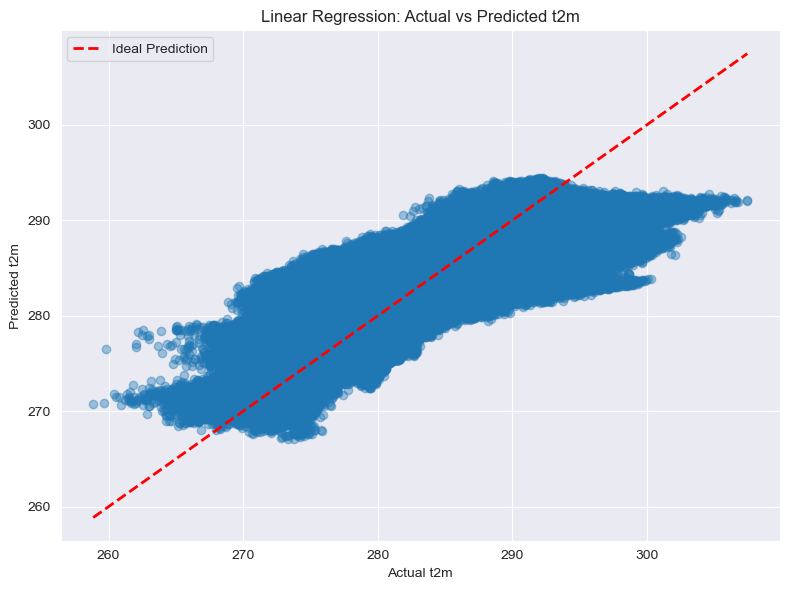

In [78]:
y_validation_pred = best_linear_regression.predict(x_validation)

In [ ]:
# Compute RMSE manually
rmse = np.sqrt(mean_squared_error(y_validation, y_validation_pred))
print(f"Validation RMSE: {round(rmse, 2)}")

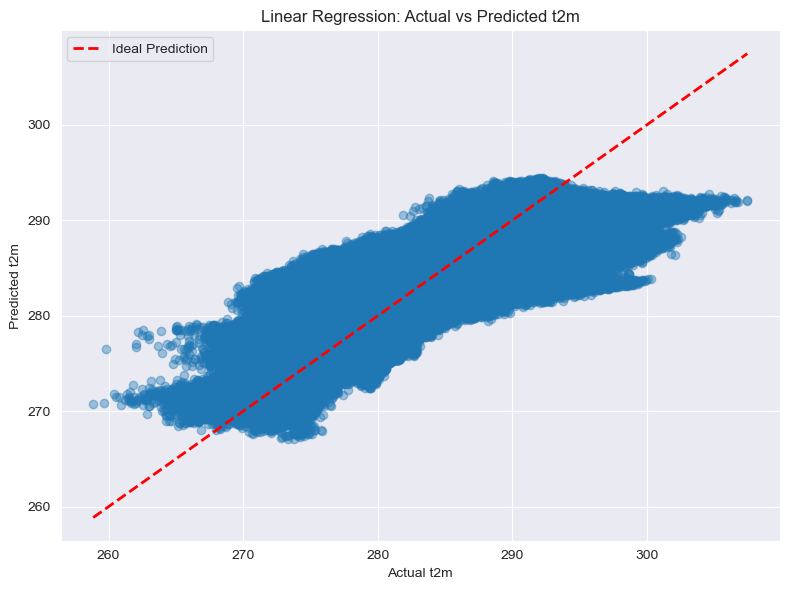

In [80]:
plt.figure(figsize=(8, 6))
plt.scatter(y_validation, y_validation_pred, alpha=0.4)
plt.plot([y_validation.min(), y_validation.max()],
         [y_validation.min(), y_validation.max()],
         color="red", linestyle="--", linewidth=2, label="Ideal Prediction")
plt.xlabel("Actual t2m")
plt.ylabel("Predicted t2m")
plt.title("Linear Regression: Actual vs Predicted t2m")
plt.legend(loc="upper left")  # or "lower right", etc.
plt.grid(True)
plt.tight_layout()
plt.show()